In [1]:
import (
	"fmt"
	"image/color"

	"gocv.io/x/gocv"
)

In [2]:
const deviceID = 0
const proto = "./human-pose-estimation-0001-int8.xml"
const model = "./human-pose-estimation-0001-int8.bin"
backend := gocv.NetBackendOpenVINO
target := gocv.NetTargetCPU

In [3]:
n := gocv.ReadNet(model, proto)
net := &n
if net.Empty() {
	fmt.Printf("Error reading network model from : %v %v\n", model, proto)
}

In [4]:
net.SetPreferableBackend(gocv.NetBackendType(backend))
net.SetPreferableTarget(gocv.NetTargetType(target))

fmt.Printf("Start reading device: %v\n", deviceID)

Start reading device: 0
24
<nil>


In [5]:
filename := "./happy-little-girl-in-grass.jpg"
img := gocv.IMRead(filename, gocv.IMReadColor)
if img.Empty() {
    panic("error to load image")
}

In [6]:
var PosePairs = [3][20][2]int{
	{ // COCO body
		{1, 2}, {1, 5}, {2, 3},
		{3, 4}, {5, 6}, {6, 7},
		{1, 8}, {8, 9}, {9, 10},
		{1, 11}, {11, 12}, {12, 13},
		{1, 0}, {0, 14},
		{14, 16}, {0, 15}, {15, 17},
	},
	{ // MPI body
		{0, 1}, {1, 2}, {2, 3},
		{3, 4}, {1, 5}, {5, 6},
		{6, 7}, {1, 14}, {14, 8}, {8, 9},
		{9, 10}, {14, 11}, {11, 12}, {12, 13},
	},
	{ // hand
		{0, 1}, {1, 2}, {2, 3}, {3, 4}, // thumb
		{0, 5}, {5, 6}, {6, 7}, {7, 8}, // pinkie
		{0, 9}, {9, 10}, {10, 11}, {11, 12}, // middle
		{0, 13}, {13, 14}, {14, 15}, {15, 16}, // ring
		{0, 17}, {17, 18}, {18, 19}, {19, 20}, // small
	}}


In [7]:
import "image"

In [8]:
func performDetection(frame gocv.Mat) [][]image.Point {

    blob := gocv.BlobFromImage(frame, 1.0, image.Pt(256, 256), gocv.NewScalar(0, 0, 0, 0), false, false)

    // feed the blob into the detector
    net.SetInput(blob, "data")
    
    // run a forward pass thru the network
    prob := net.Forward("Mconv7_stage2_L2")

    var midx int
    
    s := prob.Size()
    
    nparts, h, w := s[1], s[2], s[3]

    // find out, which model we have
    switch nparts {
    case 19:
        // COCO body
        midx = 0
        nparts = 18 // skip background
    case 16:
        // MPI body
        midx = 1
        nparts = 15 // skip background
    case 22:
        // hand
        midx = 2
    default:
        fmt.Println("there should be 19 parts for the COCO model, 16 for MPI, or 22 for the hand model")
        return nil
    }

    // find the most likely match for each part
    pts := make([]image.Point, 22)
    for i := 0; i < nparts; i++ {
        pts[i] = image.Pt(-1, -1)
        heatmap, _ := prob.FromPtr(h, w, gocv.MatTypeCV32F, 0, i)

        _, maxVal, _, maxLoc := gocv.MinMaxLoc(heatmap)

        if maxVal > 0.1 {
            pts[i] = maxLoc
        }
        heatmap.Close()
    }

    // determine scale factor
    sX := int(float32(frame.Cols()) / float32(w))
    sY := int(float32(frame.Rows()) / float32(h))

    // create the results array of pairs of points with the lines that best fit
    // each body part, e.g.
    // [[point A for body part 1, point B for body part 1],
    //  [point A for body part 2, point B for body part 2], ...]
    results := [][]image.Point{}
    for _, p := range PosePairs[midx] {
        a := pts[p[0]]
        b := pts[p[1]]

        // high enough confidence in this pose?
        if a.X <= 0 || a.Y <= 0 || b.X <= 0 || b.Y <= 0 {
            results = append(results, []image.Point{})
            continue
        }

        // scale to image size
        a.X *= sX
        a.Y *= sY
        b.X *= sX
        b.Y *= sY

        results = append(results, []image.Point{a, b})
    }
    prob.Close()
    blob.Close()

	return results
}

In [9]:
func drawPose(pose [][]image.Point, frame *gocv.Mat) {
	for _, pts := range pose {
		if len(pts) == 0 {
			continue
		}
		gocv.Line(frame, pts[0], pts[1], color.RGBA{0, 255, 0, 0}, 2)
		gocv.Circle(frame, pts[0], 3, color.RGBA{0, 0, 200, 0}, -1)
		gocv.Circle(frame, pts[1], 3, color.RGBA{0, 0, 200, 0}, -1)
	}
}


In [10]:
frame := gocv.NewMat()
img.CopyTo(&frame)
result := performDetection(frame)
frame.Close()

prob {0x7fced0033380}
<nil>


out

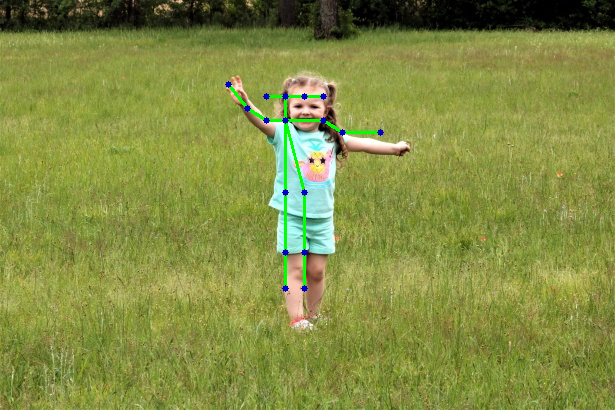

In [11]:
drawPose(result, &img)
outImgData, err := gocv.IMEncode(gocv.PNGFileExt, img)
if err!=nil {
    panic("error encode image")
}
img.Close()
_ctx.Display.Text("out", nil)
_ctx.Display.PNG(outImgData, nil)